# Step Count Analysis


> This notebook determines the 90th percentile of step count days over a one year period.

This uses the `fulcra-api-python` module, which is available on GitHub
at [https://github.com/fulcradynamics/fulcra-api-python](https://github.com/fulcradynamics/fulcra-api-python).


In [ ]:
%pip install -qU fulcra-api


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 34.1 MB/s eta 0:00:00


In [ ]:
from fulcra_api.core import FulcraAPI
import seaborn as sns

fulcra = FulcraAPI()

## Logging in to Fulcra

To make calls to the API, call `authorize()` first.  You authorize the `FulcraAPI`
instance using your browser.  The `authorize()` function will generate a link below
that you should click to log in to Fulcra.  (Depending on the notebook front-end
you're using, this tab may open automatically. On Colaboratory and other hosted
solutions, pop-up blockers usually prevent this from happening.)

Once you've logged in, close the tab; you should see "Authorization succeeded"
displayed in the notebook output.  


In [ ]:
fulcra.authorize()

## Retrieving Time Series Data

Once your `FulcraAPI` instance is authorized, you can now use it
to make API calls.

The `metric_time_series` function is used to create a Pandas dataframe.

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to fetch data for a single day
def fetch_data_for_day(day):
    try:
        start_time = day.isoformat() + "Z"
        end_time = (day + timedelta(days=1)).isoformat() + "Z"

        df = fulcra.metric_time_series(
            sample_rate=86400,  # Daily sample rate
            start_time=start_time,
            end_time=end_time,
            metric="StepCount",
        )

        return df
    except Exception as e:
        print(f"Error fetching data for {day.date()}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

# Set the year variable
year = 2023

# Start and end dates for the time period
start_date = datetime(year, 1, 1)  # Corrected to start of January
end_date = datetime(year, 12, 31)  # End of December

# Generate a list of all days in the specified time period
days = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Use ThreadPoolExecutor to make parallel API calls
with ThreadPoolExecutor(max_workers=20) as executor:
    # Submit all the tasks and get future objects
    futures = [executor.submit(fetch_data_for_day, day) for day in days]

    # As each future completes, collect the result
    dfs = [future.result() for future in as_completed(futures) if future.result() is not None and not future.result().empty]

# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True)

print(f"Data fetched from {start_date.date()} to {end_date.date()}.")
# df now holds all your step count data


Data fetched from 2023-01-01 to 2023-12-31.


<Axes: >

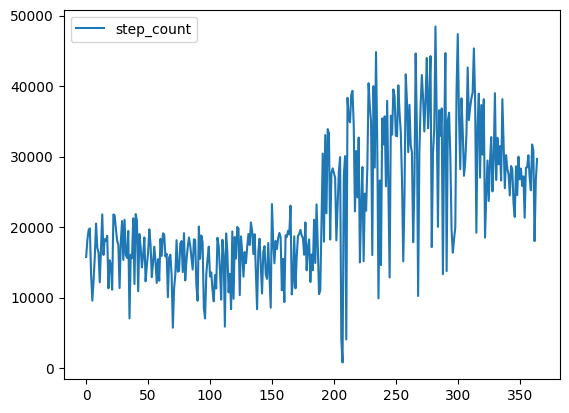

In [ ]:
df.plot()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.style as style
import missingno as msno

# Assuming df is your DataFrame with an index based on dates and a 'step_count' column

print(f"Data Available from {df.index.min()} to {df.index.max()}")

# Calculate the 90th percentile of step counts across all days
percentile_90 = df['step_count'].quantile(0.9)

print(f"The 90th percentile of daily step counts across all days is {percentile_90:.0f} steps.")


Data Available from 0 to 364
The 90th percentile of daily step counts across all days is 37038 steps.


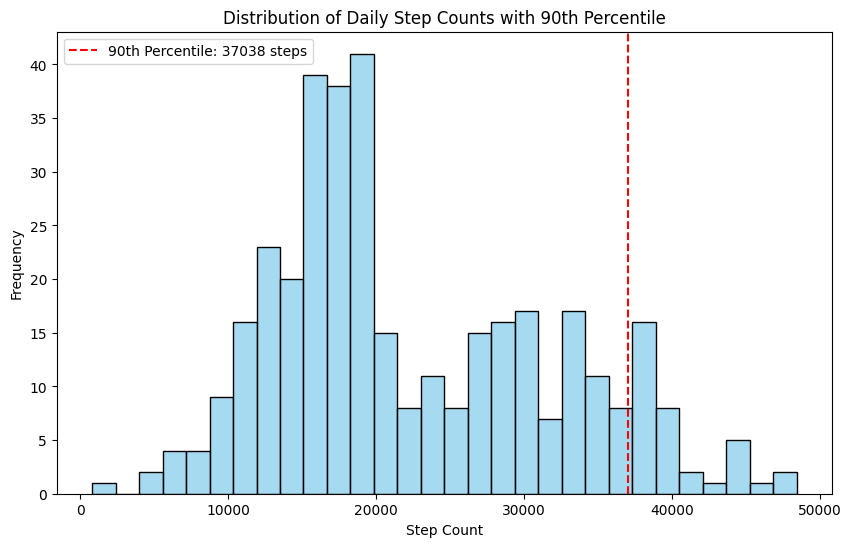

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with a 'step_count' column
percentile_90 = df['step_count'].quantile(0.9)

# Plotting the distribution of step counts
plt.figure(figsize=(10, 6))
sns.histplot(df['step_count'], bins=30, kde=False, color='skyblue')

# Adding a vertical line for the 90th percentile
plt.axvline(x=percentile_90, color='red', linestyle='--', label=f'90th Percentile: {percentile_90:.0f} steps')

plt.title('Distribution of Daily Step Counts with 90th Percentile')
plt.xlabel('Step Count')
plt.ylabel('Frequency')
plt.legend()

plt.show()
